Classify students into High/Medium/Low Performers with Use of Classification Models

In [147]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.6/150.0 MB 38.1 MB/s eta 0:00:04
   - -------------------------------------- 4.7/150.0 MB 10.6 MB/s eta 0:00:14
   - -------------------------------------- 5.0/150.0 MB 10.8 MB/s eta 0:00:14
   - -------------------------------------- 6.0/150.0 MB 7.0 MB/s eta 0:00:21
   -- ------------------------------------- 7.6/150.0 MB 7.1 MB/s eta 0:00:20
   -- ------------------------------------- 8.7/150.0 MB 6.8 MB/s eta 0:00:21
   -- ------------------------------------- 9.7/150.0 MB 6.4 MB/s eta 0:00:22
   -- ------------------------------------- 10.5/150.0 MB 6.2 MB/s eta 0:00:23
   --- ------------------------------------ 12.1/150.0 MB 6.2 MB/s eta 0:00:23
   --- ------------------------------------ 13.1/150.0 MB 6.2 MB/s eta 0:00:23
   --- ------------------------------------ 13.9/150.0 MB 5.9 MB/s eta 0:00:24
   --- ------------------------------------ 14.9/150.0 MB 5.8 MB

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [260]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


Phase 1 : Importing Data and Feature Engineering

In [172]:
df=pd.read_csv("StudentsPerformance.csv")

In [174]:
df.shape

(1000, 8)

In [176]:
def get_level(score):
    if score >= 70:
        return 'High'
    elif score >= 40:
        return 'Medium'
    else:
        return 'Low'
df['avg score']=(df['math score']+df['reading score']+df['writing score'])/3
df['performance']=df['avg score'].apply(get_level)

Phase 2 : Exploratory Data Analysis

In [179]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,avg score,performance
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,High
1,female,group C,some college,standard,completed,69,90,88,82.333333,High
2,female,group B,master's degree,standard,none,90,95,93,92.666667,High
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,Medium
4,male,group C,some college,standard,none,76,78,75,76.333333,High


In [181]:
df['performance'].value_counts()

performance
Medium    511
High      459
Low        30
Name: count, dtype: int64

In [183]:
df.isnull().sum().sum()

0

Phase 3 : Encoding

In [224]:
categorical_cols = ['gender', 'race/ethnicity','lunch', 'parental level of education', 'test preparation course']
le=LabelEncoder()
for col in categorical_cols:
    df[col]=le.fit_transform(df[col])

In [226]:
df['performance']=le.fit_transform(df['performance'])

In [228]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,avg score,performance
0,0,1,1,1,1,72,72,74,72.666667,0
1,0,2,4,1,0,69,90,88,82.333333,0
2,0,1,3,1,1,90,95,93,92.666667,0
3,1,0,0,0,1,47,57,44,49.333333,2
4,1,2,4,1,1,76,78,75,76.333333,0


In [230]:
df['performance'].value_counts()

performance
2    511
0    459
1     30
Name: count, dtype: int64

Phase 4 : Visualizations

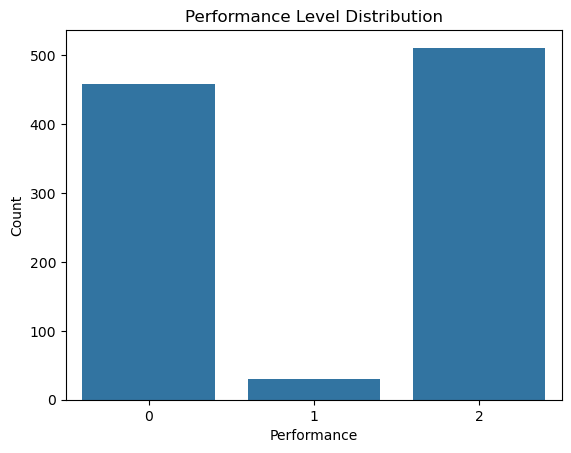

In [233]:
# Class Distrubution of Target
sns.countplot(x='performance',data=df)
plt.title("Performance Level Distribution")
plt.xlabel('Performance')
plt.ylabel('Count')
plt.show()

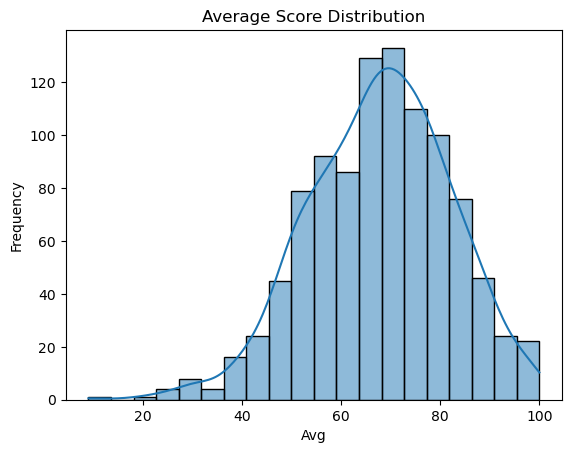

In [326]:
# Distribution of Average Scores
sns.histplot(df['avg score'],kde=True,bins=20)
plt.title("Average Score Distribution")
plt.xlabel('Avg')
plt.ylabel('Frequency')
plt.show()

In [238]:
skew_value=df['avg score'].skew()
print(f"Skewness:{skew_value: .3f}")

Skewness:-0.299


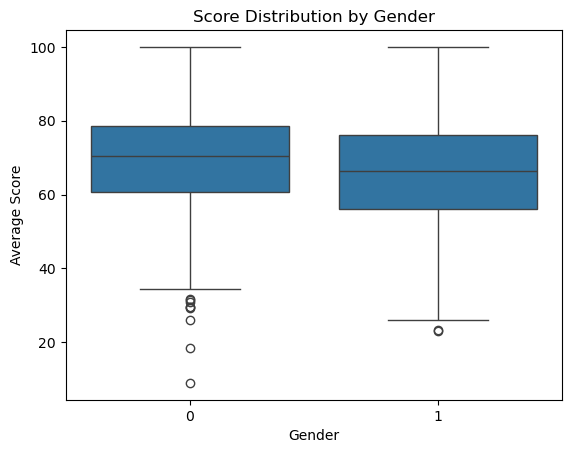

In [240]:
#Boxplot of Average Score by Gender
sns.boxplot(x='gender', y='avg score', data=df)
plt.title("Score Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Score")
plt.show()


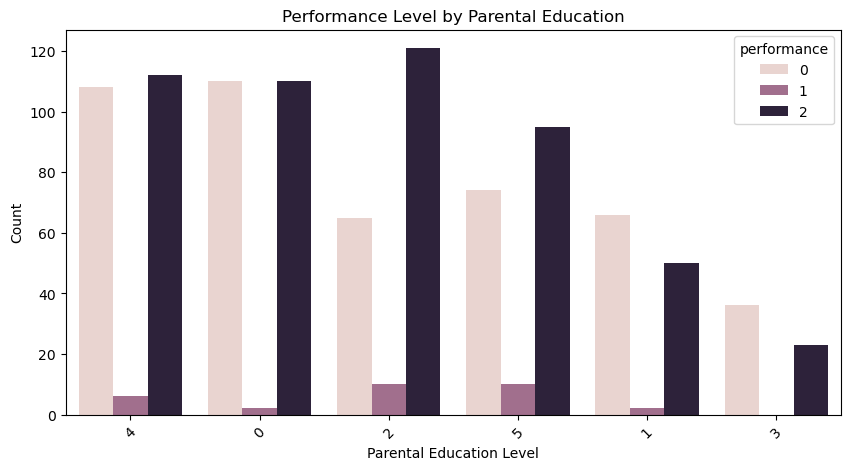

In [242]:
# Performance vs Parental Education
plt.figure(figsize=(10, 5))
sns.countplot(x='parental level of education', hue='performance', data=df,
              order=df['parental level of education'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Performance Level by Parental Education")
plt.xlabel("Parental Education Level")
plt.ylabel("Count")
plt.show()


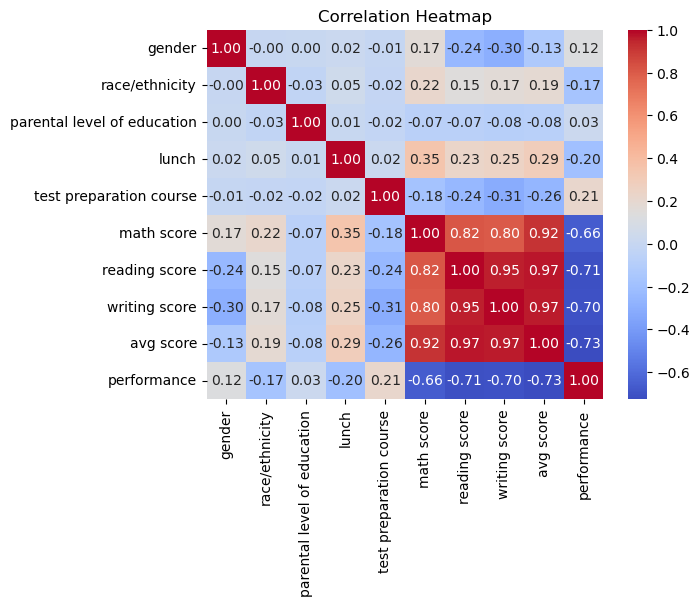

In [244]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


Phase 5 : Splitting Data

In [292]:
x = df.drop(['performance'],axis=1)
y = df['performance']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

#SMOTE
sm =SMOTE(random_state=42)
x_train_resampled,y_train_resampled=sm.fit_resample(x_train,y_train)

Phase 6 : MODEL TRAINING

In [294]:
lr=LogisticRegression(max_iter=1000)
lr.fit(x_train_resampled,y_train_resampled)
y_pred_lr=lr.predict(x_test)

In [296]:
rf=RandomForestClassifier()
rf.fit(x_train_resampled,y_train_resampled)
y_pred_rf=rf.predict(x_test)

In [298]:
xgb=XGBClassifier(use_label_encoder=False,eval_metrics='mlogloss')
xgb.fit(x_train_resampled,y_train_resampled)
y_pred_xgb=xgb.predict(x_test)

Phase 7 : Evaluation

In [300]:
#Evaluation Function
def evaluate_model(name,y_true,y_pred):
    print(f"\n==={name}===")
    print("Accuracy: ",accuracy_score(y_true,y_pred))
    print("Confusion Matrix: \n")

In [304]:
evaluate_model("Logistic Regression",y_test,y_pred_lr)
evaluate_model("Random Forest",y_test,y_pred_rf)
evaluate_model("XGBoost",y_test,y_pred_xgb)


===Logistic Regression===
Accuracy:  0.95
Confusion Matrix: 


===Random Forest===
Accuracy:  1.0
Confusion Matrix: 


===XGBoost===
Accuracy:  1.0
Confusion Matrix: 



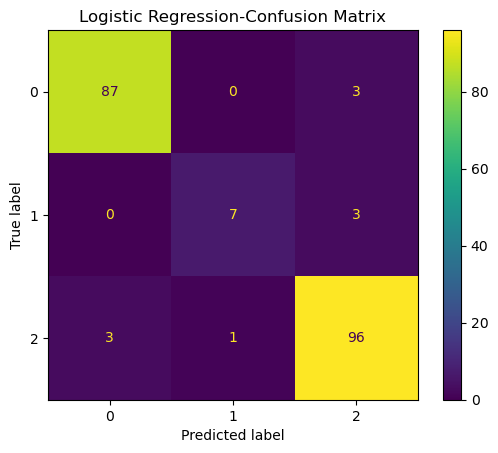

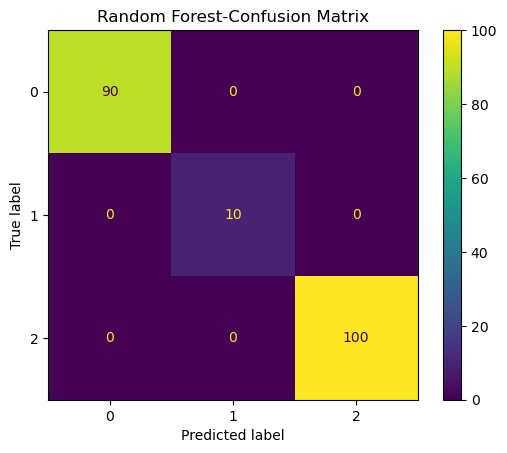

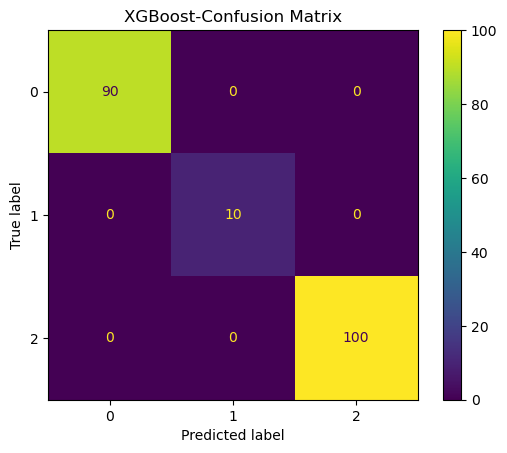

In [314]:
models={
    'Logistic Regression':y_pred_lr,
    'Random Forest':y_pred_rf,
    'XGBoost':y_pred_xgb
}
for name,preds in models.items():
    disp=ConfusionMatrixDisplay.from_predictions(y_test,preds)
    plt.title(f"{name}-Confusion Matrix")
    plt.show()

In [306]:
print('===Logistic Regression===')
print(classification_report(y_test,y_pred_lr))

===Logistic Regression===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        90
           1       0.88      0.70      0.78        10
           2       0.94      0.96      0.95       100

    accuracy                           0.95       200
   macro avg       0.93      0.88      0.90       200
weighted avg       0.95      0.95      0.95       200



In [308]:
print('===Random Forest===')
print(classification_report(y_test,y_pred_rf))

===Random Forest===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [310]:
print('===XGBoost===')
print(classification_report(y_test,y_pred_xgb))

===XGBoost===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



 Phase 8 : Model Recommendation

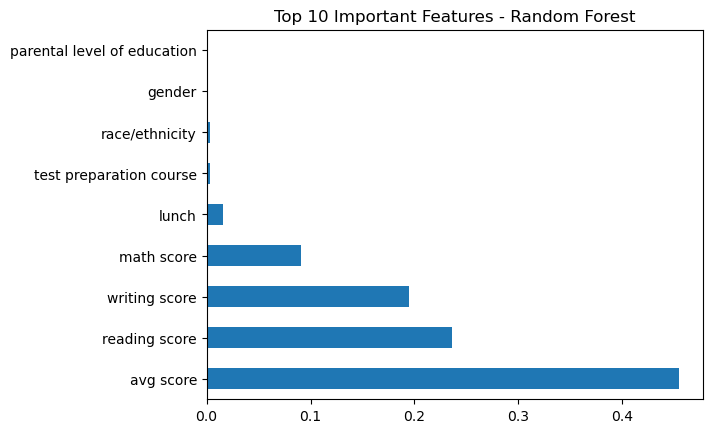

In [323]:
#Feature Importance
feat_importance = pd.Series(rf.feature_importances_, index=x_train.columns)
feat_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features - Random Forest")
plt.show()